## Sorting array vs casting to a set

In [4]:
import numpy as np
import time 

def generate_random_arrays(n):
    return np.random.randint(0, 10, size=(n, 9))

def uniqueness_test_1(l):
    l1 = set(l)
    return len(l) == 9 and 0 not in l1

def uniqueness_test_2(l):
    return np.sort(l) == np.arange(1, 10)

In [5]:
data = generate_random_arrays(1000000)

start = time.time()

for i in data:
    uniqueness_test_1(i)

end = time.time()
print(f"Runtime of set implemetation: {end - start:.3f}")

start = time.time()

for i in data:
    uniqueness_test_2(i)

end = time.time()
print(f"Runtime of sorting implemetation: {end - start:.3f}")

Runtime of set implemetation: 1.135
Runtime of sorting implemetation: 2.266


## Numba

In [1]:
from src.Sudoku import Sudoku
import numpy as np


grid1 = """000801000
    000000043
    500000000
    000070800
    000000100
    020030000
    600000075
    003400000
    000200600"""

sudoku = Sudoku(grid1)


In [2]:
from numba import jit, prange

def calculate_candidates(sudoku):

    candidates = np.zeros([9, 9]) 

    for y in range(9):
        for x in range(9):
            if sudoku.get_cell(x, y) != 0:
                candidates[y][x] = 0
                continue

            row = sudoku.get_row(y)
            col = sudoku.get_col(x)
            sq_index = x // 3 + 3 * (y // 3)
            sq = sudoku.get_square(sq_index)
            invalid_numbers = np.concatenate((row, col, sq.flatten()))
            valid_numbers = np.setdiff1d(np.arange(1, 10), invalid_numbers)
            candidates[y][x] = len(valid_numbers)

    return candidates


@jit(nopython=True)
def custom_setdiff1d(ar1, ar2):
    result = []
    
    ar2_set = set(ar2)
    
    for item in ar1:
        if item not in ar2_set:
            result.append(item)
    
    return np.array(result)

@jit(nopython=True, parallel=True)
def calculate_candidates_2(grid: np.array):

    candidates = np.zeros((9, 9, 9), dtype=np.bool_)

    for y in prange(9):
        for x in prange(9):
            if grid[y, x] != 0:
                continue

            row = grid[y, :]
            col = grid[:, x]
            y0 = (y // 3) * 3
            x0 = (x // 3) * 3
            sq = grid[y0 : y0 + 3, x0 : x0 + 3]
            invalid_numbers = np.concatenate((row, col, sq.flatten()))
            valid_numbers = custom_setdiff1d(np.arange(1, 10), invalid_numbers)
            candidates[y, x, valid_numbers - 1] = 1

    return candidates


In [8]:
import time

start_time = time.time()

for _ in range(100000):
    c = calculate_candidates_2(sudoku.grid)

end_time = time.time()

print(f"Time: {end_time - start_time}")


Time: 14.544921398162842


In [10]:
def decode_candidates(c):
    candidates = []
    for row in c:
        new_row = []
        for elem in row:
            new_row.append([i + 1 for i, e in enumerate(elem) if e])
        candidates.append(new_row)
    
    return candidates

In [15]:
grid_of_candidates = decode_candidates(c)
for row in grid_of_candidates:
    for cell in row:
        if cell:
            print("".join([str(i) for i in cell]), end=" ")
        else:
            print("-1", end=" ")
    print()


23479 34679 24679 -1 24569 -1 2579 2569 2679 
12789 16789 126789 5679 2569 25679 2579 -1 -1 
-1 1346789 1246789 3679 2469 234679 279 12689 126789 
1349 134569 14569 1569 -1 24569 -1 23569 2469 
34789 3456789 456789 569 245689 245689 -1 23569 24679 
14789 -1 1456789 1569 -1 45689 4579 569 4679 
-1 1489 12489 139 189 389 2349 -1 -1 
12789 15789 -1 -1 15689 56789 29 1289 1289 
14789 145789 145789 -1 1589 35789 -1 1389 1489 


## Numpy array vs python list for storing candidates

In [6]:
import numpy as np


def grid_of_candidates_list():
    grid_of_candidates = [[[] for _ in range(9)] for _ in range(9)]
    for y in range(9):
        for x in range(9):
            grid_of_candidates[y][x] = [1, 2, 3, 4]

    return grid_of_candidates


def grid_of_candidates_array():
    grid_of_candidates = np.empty((9, 9), dtype=object)
    for y in range(9):
        for x in range(9):
            grid_of_candidates[y, x] = [1, 2, 3, 4]

    return grid_of_candidates

In [12]:
import time

n = 100000
implementations = [("List", grid_of_candidates_list), ("Array", grid_of_candidates_array)]

for i in implementations:
    start = time.time()
    for _ in range(n):
        grid = i[1]()
        for row in grid:
            for elem in row:
                elem

    end = time.time()
    print(f"{i[0]} implementation: {end - start:.3f}")


List implementation: 1.666
Array implementation: 2.149


In [2]:
from src.Sudoku import Sudoku
from src.SudokuAnalyzer import SudokuAnalyzer

grid = "370009405094070300086500000718000050900600037003010009069180003031950084857030090"

sudoku = Sudoku(grid)
analyzer = SudokuAnalyzer(sudoku)
analyzer.get_sudoku_description()

(116, 39, 2.94)

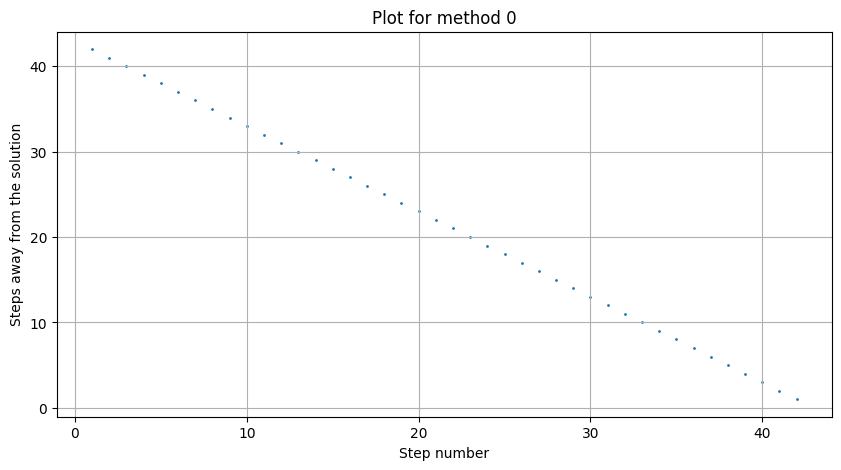

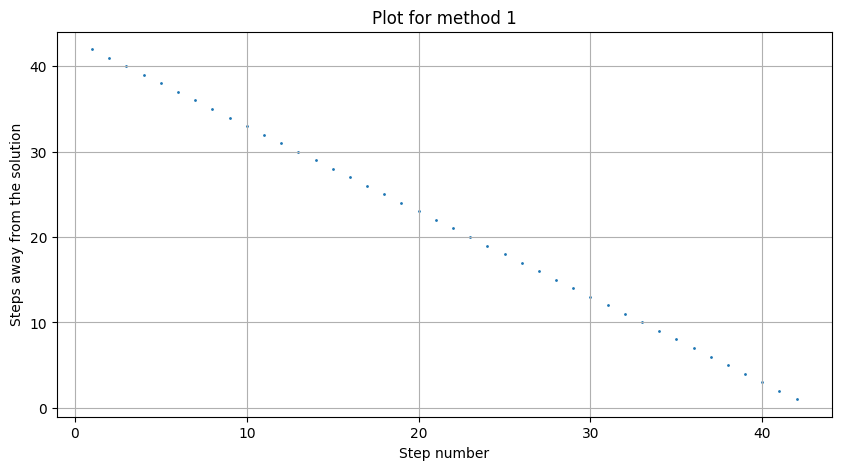

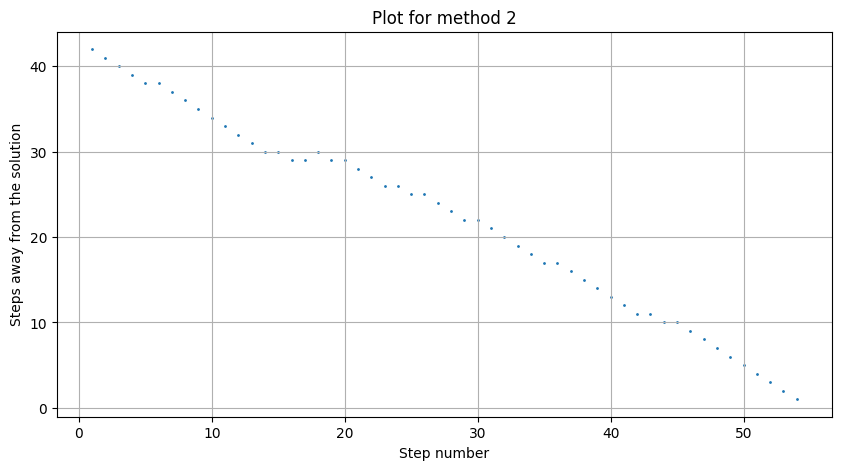

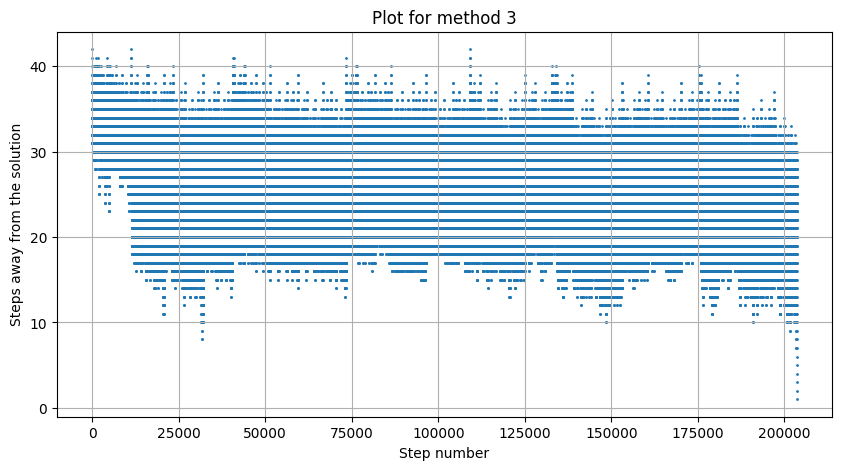

In [5]:
import matplotlib.pyplot as plt

def plot_data_points(i):
    with open(f'solver_logs/m{i}.txt', 'r') as file:
        lines = file.readlines()

    Y = [(81 - 39) - int(line.split()[3]) for line in lines]
    X = list(range(1, len(Y) + 1))

    plt.figure(figsize=(10, 5))
    plt.scatter(X, Y, s=1)
    plt.title(f'Plot for method {i}')
    plt.xlabel('Step number')
    plt.ylabel('Steps away from the solution')
    plt.grid(True)
    plt.show()


for i in range(4):
    plot_data_points(i)


## Linear search vs binary search

In [8]:
import numpy as np
import time 
from src.SudokuDB import SudokuDB

n = 30


db = SudokuDB()
test_data = np.random.uniform(low=1, high=10, size=n)
implementations = [("Binary search", db.get_sudoku_by_diff_2), ("Linear search", db.get_sudoku_by_diff)]
answers = []
for i in implementations:
    results = []
    start = time.time()

    for d in test_data:
        results.append(i[1](d)) 

    end = time.time()

    answers.append(results)
    print(f"{i[0]} runtime: {end - start:.4f}")

Binary search runtime: 0.0338
Linear search runtime: 43.2358
